# Test on the IIHR Dune

This page is updated from the 'queens_dune_test_Oct_21_2015,ipynb' 

See notes from Tuesday August 16, 2016 for a description of what is happening. 

In [95]:
import matplotlib
import matplotlib.pyplot as plt
import cython
import sys, os
import numpy as np
from scipy.interpolate import interp1d

import collections

sys.path.append(r"C:\Users\pgrover\Documents\code\pymorph")
sys.path.append(r"C:\Users\pgrover\Documents\code\pymorph\schemes")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans
#from models.shallow_water_solver import shallow_solver
from schemes.avalanche_scheme import *

from scipy.signal import savgol_filter

%load_ext cython
%matplotlib inline
%load_ext autoreload
%autoreload 2



The cython extension is already loaded. To reload it, use:
  %reload_ext cython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
retval = collections.OrderedDict()

In [5]:
def runModel(qbedload_filepath, simTime, dt=1):
    
    qbedload = []
    with open(qbedload_filepath) as f:
        for line in f:
            values = line.split()
            if len(values) > 0:
                qbedload.append(float(line))


    qbedload = np.array(qbedload)
    print(qbedload.shape)
    #--------------------------------
    #  Setup the model run parameters
    #--------------------------------
    nt = int(simTime/dt)  # Number of time steps


    #--------------------------------
    # Set up the constants
    #--------------------------------
    a=0.001
    b=3.0
    Q=10.0
    nP=0.4

    s= 0.2      # Surface water elevation
    beta = 0.01

    # Sediment properties
    D50 = 0.001     # Particle Diameter
    rho_particule = 2650

    #--------------------------------
    # Set up the domain, BCs and ICs
    #--------------------------------

    print('Grid dx = {0}'.format(dx))
    print('Grid nx = {0}'.format(len(xc)))

    zc = z.copy()
    z_hydro = z.copy()


    #--------------------------------
    # Initialize the sed transport 
    #--------------------------------    
    # Eq 57
    #qbedload = np.zeros(nx)
    roe_speed = np.zeros(nx)
    #qbedload = a*u**b
    flux = np.zeros(nx)


    #--------------------------------
    # Set up the model reporting parameters
    #--------------------------------
    z0 = zc.copy() 
    z600 = zc.copy() 
    z2000 = zc.copy()
    verts = []
    extractionInterval = 100.
    tsteps=[]
    iterations = 0
    cntr=0
    plt.plot(xc,z)
    print(xc.shape, qbedload.shape)
    plt.plot(xc,qbedload*10000.)

    #--------------------------------
    #  Run the model
    #--------------------------------
    for n in range(1,nt):  
        zn = zc.copy() 
        for i in range(0,nx): #i=2
            zloc = get_stencil(zn,i-2,i+4)        
            # Since k=3
            # stencil is i-2 to i+2 
            qloc = get_stencil(qbedload,i-2,i+4)
            
            
            
            
            if len(qloc)!=6:
                raise ValueError('Stencil is incorrect')

            # Determine the Upwind flux
            # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
            # this is the evaluation of the left and right based fluxes. Eq. 18 and 19        
            if (zloc[3]-zloc[2]) == 0.0:
                roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
            else:
                roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )

            if roe_speed[i] >= 0.0:
                flux[i] = get_left_flux(qloc)
            else:
                flux[i] = get_right_flux(qloc)

        # Need the sign of the phase speed
        # Need to check this out
        for i in range(0,nx): #i=2       
            floc = get_stencil(flux,i-1,i+1)
            zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(floc[1]-floc[0])

        bed_max_delta = np.max(np.abs(zn - zc))

        # Apply the avalanche model
        zc,iterations1 = avalanche_model(dx,xc,zc)


        slope = np.gradient(zc,dx)
        
        
        
        

        # Here we are leaving the qbedload constant
        '''
        for i in range(0,nx): #i=2        
            zlocal = get_stencil(zc,i-2,i+2)
            qbedload[i] = sedtrans.get_unit_bed_load_slope(h[i],u[i],D50,slope[i], 
                                                           rho_particule, angleReposeDegrees = 30.0, type='mpm')
            #qbedload[i] = sedtrans.get_unit_bed_load2(h[i],u[i],D50,rho_particule, type='mpm')
        '''
        if (n*dt / extractionInterval) == math.floor(n*dt / extractionInterval):
            verts.append(list(zip(xc.copy(),zc.copy())))
            tsteps.append(n*dt)        
            np.save('flume_dunes', verts)

        cntr += 1
        if cntr == 100:
            cntr = 0
            print('Time step {0} of {1} - bed_max_delta {2}'.format(n,nt,bed_max_delta))    

    print('Done')
    return zc, qbedload



In [132]:
def runModel2(bed_shear_path, z, xc, simTime, dt=1):
    
    #--------------------------------
    #  Setup the model run parameters
    #--------------------------------
    nt = int(simTime/dt)  # Number of time steps

    #--------------------------------
    # Set up the constants
    #--------------------------------
    a=0.001
    b=3.0
    Q=10.0
    nP=0.4

    s= 0.2      # Surface water elevation
    beta = 0.01

    # Sediment properties
    D50 = 0.00025     # Particle Diameter
    rho_particule = 2650

    #--------------------------------
    # Set up the domain, BCs and ICs
    #--------------------------------
    nc = len(xc)
    print('Grid dx = {0}'.format(dx))
    print('Grid nx = {0}'.format(len(xc)))

    zc = z.copy()
    z_hydro = z.copy()
    
    slope = np.gradient(zc,dx)
    
    
    #--------------------------------
    # Initialize the sed transport 
    #--------------------------------    
    
    qbedload = np.zeros(nc)
    bedShear = []
    with open(bed_shear_path) as f:
        for line in f:
            values = line.split()
            if len(values) > 0:
                bedShear.append(float(line))
    bedShear = np.array(bedShear)
    
    
    print('Slope shape: {0}'.format(slope.shape))
    print('bedShear shape: {0}'.format(bedShear.shape))
    
    
    for i in range(0,nx):
            qbedload[i] = sedtrans.get_unit_bed_load_slope_shear(bedShear[i], D50, slope[i], \
                                                        rho_particule, angleReposeDegrees=30.0, type='bagnold')

    qbedload = np.array(qbedload)
    qbedload = savgol_filter(qbedload, 25,2)
    print('qbedload shape: {0}'.format(qbedload.shape))


    
    # Eq 57
    #qbedload = np.zeros(nx)
    roe_speed = np.zeros(nx)
    #qbedload = a*u**b
    flux = np.zeros(nx)


    #--------------------------------
    # Set up the model reporting parameters
    #--------------------------------
    z0 = zc.copy() 
    z600 = zc.copy() 
    z2000 = zc.copy()
    verts = []
    extractionInterval = 100.
    tsteps=[]
    iterations = 0
    cntr=0
    plt.plot(xc,z)
    print(xc.shape, qbedload.shape)
    plt.plot(xc,qbedload*10000.)

    #--------------------------------
    #  Run the model
    #--------------------------------
    for n in range(1,nt):  
        zn = zc.copy() 
        for i in range(0,nx): #i=2
            zloc = get_stencil(zn,i-2,i+4)        
            # Since k=3
            # stencil is i-2 to i+2 
            qloc = get_stencil(qbedload,i-2,i+4)          
            
            
            
            if len(qloc)!=6:
                raise ValueError('Stencil is incorrect')

            # Determine the Upwind flux
            # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
            # this is the evaluation of the left and right based fluxes. Eq. 18 and 19        
            if (zloc[3]-zloc[2]) == 0.0:
                roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
            else:
                roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )

            if roe_speed[i] >= 0.0:
                flux[i] = get_left_flux(qloc)
            else:
                flux[i] = get_right_flux(qloc)

        # Need the sign of the phase speed
        # Need to check this out
        for i in range(0,nx): #i=2       
            floc = get_stencil(flux,i-1,i+1)
            zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(floc[1]-floc[0])

        bed_max_delta = np.max(np.abs(zn - zc))

        # Apply the avalanche model
        zc,iterations1 = avalanche_model(dx,xc,zc)


        slope = np.gradient(zc,dx)
        
        for i in range(0,nx):
            qbedload[i] = sedtrans.get_unit_bed_load_slope_shear(bedShear[i], D50, slope[i], \
                                                        rho_particule, angleReposeDegrees=30.0, type='bagnold')
        
        #qbedload = savgol_filter(qbedload, 25,2)
        zc = savgol_filter(zc, 25,2)
        # Here we are leaving the qbedload constant
        '''
        for i in range(0,nx): #i=2        
            zlocal = get_stencil(zc,i-2,i+2)
            qbedload[i] = sedtrans.get_unit_bed_load_slope(h[i],u[i],D50,slope[i], 
                                                           rho_particule, angleReposeDegrees = 30.0, type='mpm')
            #qbedload[i] = sedtrans.get_unit_bed_load2(h[i],u[i],D50,rho_particule, type='mpm')
        '''
        if (n*dt / extractionInterval) == math.floor(n*dt / extractionInterval):
            verts.append(list(zip(xc.copy(),zc.copy())))
            tsteps.append(n*dt)        
            np.save('flume_dunes', verts)

        cntr += 1
        if cntr == 100:
            cntr = 0
            print('Time step {0} of {1} - bed_max_delta {2}'.format(n,nt,bed_max_delta))    

    print('Done')
    return zc, qbedload,slope

['ncols', '1']
['nrows', '194']
['xllcorner', '0']
['yllcorner', '0']
['cellsize', '0.002']
['NODATA_value', '-9999']
Z: 194
(194,)
Grid dx = 0.002
Grid nx = 194
(194,) (194,)
Time step 100 of 180 - bed_max_delta 8.818843611957394e-05
Done
(200,)
Grid dx = 0.002
Grid nx = 194
(194,) (200,)


ValueError: x and y must have same first dimension, but have shapes (194,) and (200,)

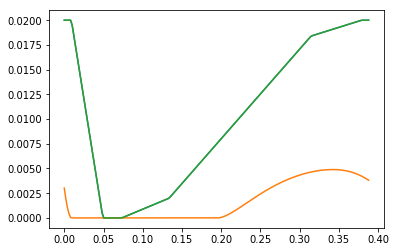

In [124]:
#%%cython




casefolder = r'c:\Users\pgrover\Dropbox\PhD\Papers\Paper 1 - Application of OpenFoam to simulate the flow over fixed dunes\geometry'


filepath = os.path.join(casefolder, 'flume_profile_v001.txt')

z = []
with open(filepath) as f:
    for line in f:

        values = line.split()
        if len(values) > 0:
            if is_number(values[0])==False:
                print(values)
                if float(values[1]).is_integer():
                    retval[values[0]]=int(values[1])
                else:
                    retval[values[0]]=float(values[1])
            else:

                if is_number(values[0])==True:
                    z.append(float(values[0]))
z = np.array(z)
print('Z: {0}'.format(len(z)))
xmax = float(retval['nrows']) * retval['cellsize']
nx = retval['nrows']
dx = retval['cellsize']

xc = np.linspace(0,xmax,nx)


filepath = os.path.join(casefolder,'6cm', 'bed_load.kwsst.txt')
z_kwsst, qbedload_kwsst = runModel(filepath, 180, dt=1)


filepath = os.path.join(casefolder, '6cm', 'bed_load.ke.txt')
z_ke, qbedload_ke = runModel(filepath, 180, dt=1)

filepath = os.path.join(casefolder, '6cm', 'bed_load.kwbsl.txt')
#z_kwbsl, qbedload_kwbsl = runModel(filepath, 180, dt=1)






In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 4))
plt.plot(xc,z_kwsst, 'k', linestyle='--', label='final bed - ke', linewidth=1.5)
plt.plot(xc,z_ke,'k', linestyle='-.', label='final bed - ke', linewidth=0.5)
#plt.plot(xc,z_kwbsl,'g', linestyle='-.', label='final bed - ke', linewidth=1.5)



In [ ]:
from matplotlib import rc, rcParams
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=False)
#plt.rcParams["font.family"] = "Times New Roman"

rcParams['mathtext.default'] = 'regular'

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 4))


xr = (xc/0.02) - 0.5

ax1.plot(xr,z_kwsst,'k', linestyle='-', label='$k-\omega$ SST', linewidth=1.)
plt.plot(xr,z_kwbsl,'k', linestyle='--', label='$k-\omega$ BSL', linewidth=1.)
ax1.plot(xr,z_ke,'k', linestyle='-.', label='LS $k-\epsilon$', linewidth=1.)

ax1.plot(xr,z,'k', linestyle='-', label='initial bed', linewidth=3.5)
plt.xlabel('$x/\Delta$', fontsize='14')
plt.ylabel('$z/\Delta$', fontsize='14')
#plt.xlim([5., 14.])
#plt.ylim([0., 0.02])

plt.tick_params(axis='both', which='major', labelsize=16)
for item in([ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(25)
plt.legend()

#ax2 = ax1.twinx()
#ax2.plot(xc,qbedload*1000.,'k', label='bed load', linewidth=1.0, linestyle='-.')

Grid dx = 0.002
Grid nx = 194
Slope shape: (194,)
bedShear shape: (194,)
qbedload shape: (194,)
(194,) (194,)
Done


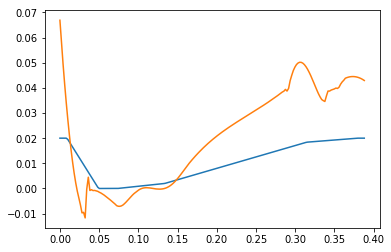

In [133]:
time = 20

filepath = os.path.join(casefolder,'12cm', 'bed_shear.kwsst.txt')
#z_kwsst_12, qbedload_kwsst = runModel(filepath, time, dt=1)
z_kwsst_12, qbedload_kwsst, slope_kwsst = runModel2(filepath, z, xc, time, dt=1)


filepath = os.path.join(casefolder, '12cm', 'bed_load.ke.txt')
#z_ke_12, qbedload_ke = runModel(filepath, time, dt=1)

filepath = os.path.join(casefolder, '12cm', 'bed_load.kwsst.raw.txt')
#z_kwbsl_12, qbedload_kwbsl = runModel(filepath, time, dt=1)


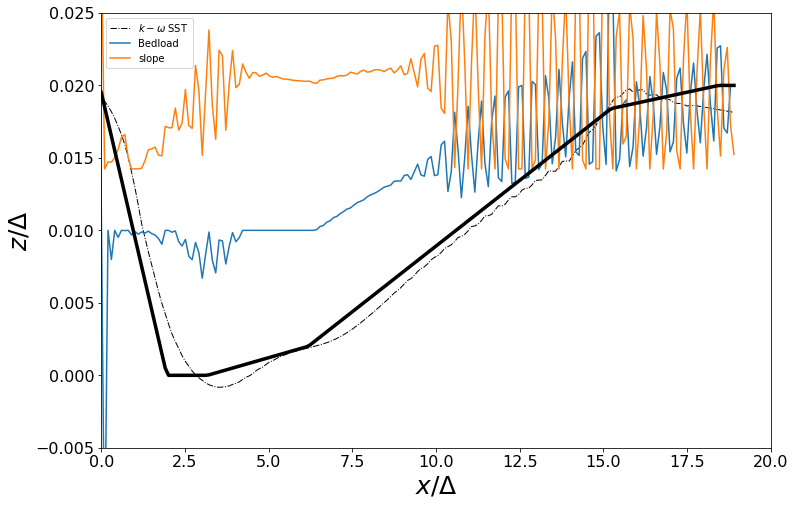

In [134]:
fig, ax1 = plt.subplots(figsize=(12, 8))


xr = (xc/0.02) - 0.5

ax1.plot(xr,z_kwsst_12,'k', linestyle='-.', label='$k-\omega$ SST', linewidth=1.)
#plt.plot(xr,z_kwbsl_12,'k', linestyle='--', label='$k-\omega$ BSL', linewidth=1.)
#ax1.plot(xr,z_ke_12,'k', linestyle='-.', label='LS $k-\epsilon$', linewidth=1.)

plt.plot(xr, 0.01 + qbedload_kwsst*2000, label='Bedload')

plt.plot(xr,slope_kwsst/100. + 0.02, label='slope')
#plt.plot(xr, 0.01 + qbedload_ke*2000)

ax1.plot(xr,z,'k', linestyle='-', linewidth=3.5)
plt.xlabel('$x/\Delta$', fontsize='14')
plt.ylabel('$z/\Delta$', fontsize='14')
plt.xlim([0, 20.])
plt.ylim([-0.005, 0.025])

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=16)
for item in([ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(25)

In [127]:
smoothq = savgol_filter(qbedload_kwsst, 25,2)

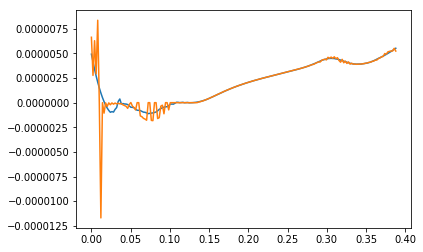

In [128]:
plt.plot(xc, smoothq)
plt.plot(xc, qbedload_kwsst)

In [41]:
import pandas as pd
keDf = pd.DataFrame(xr,z_ke_12)
keDf.to_csv('z_ke_12.csv')

PermissionError: [Errno 13] Permission denied: 'z_ke_12.csv'

In [ ]:
plt.rcParams["font.family"] = "Times New Roman"

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(xc/0.02,zke/0.02,'g', linestyle='--', label='$LS k-\epsilon$', linewidth=1.5)

ax1.plot(xc/0.02,zkw/0.02,'r', linestyle='-.', label='$k-\omega$ SST', linewidth=1.5)

ax1.plot(xc/0.02,z/0.02,'k', linestyle='-', label='Initial Bed', linewidth=1.5)

plt.xlabel('$x/\Delta$', fontsize='14')
plt.ylabel('$z/\Delta$', fontsize='14')
#plt.xlim([3.5, 14])
#plt.ylim([-0.25, 1])
plt.legend(fontsize='14')

ax2 = ax1.twinx()
ax2.plot(xc/0.02,qbedloadke*1000.,'b', label='bed load', linewidth=1.0, linestyle='-')

ax2.plot(xc/0.02,qbedloadkw*1000.,'m', label='bed load', linewidth=1.0, linestyle='-')

ax2.set_ylabel('Qsb')

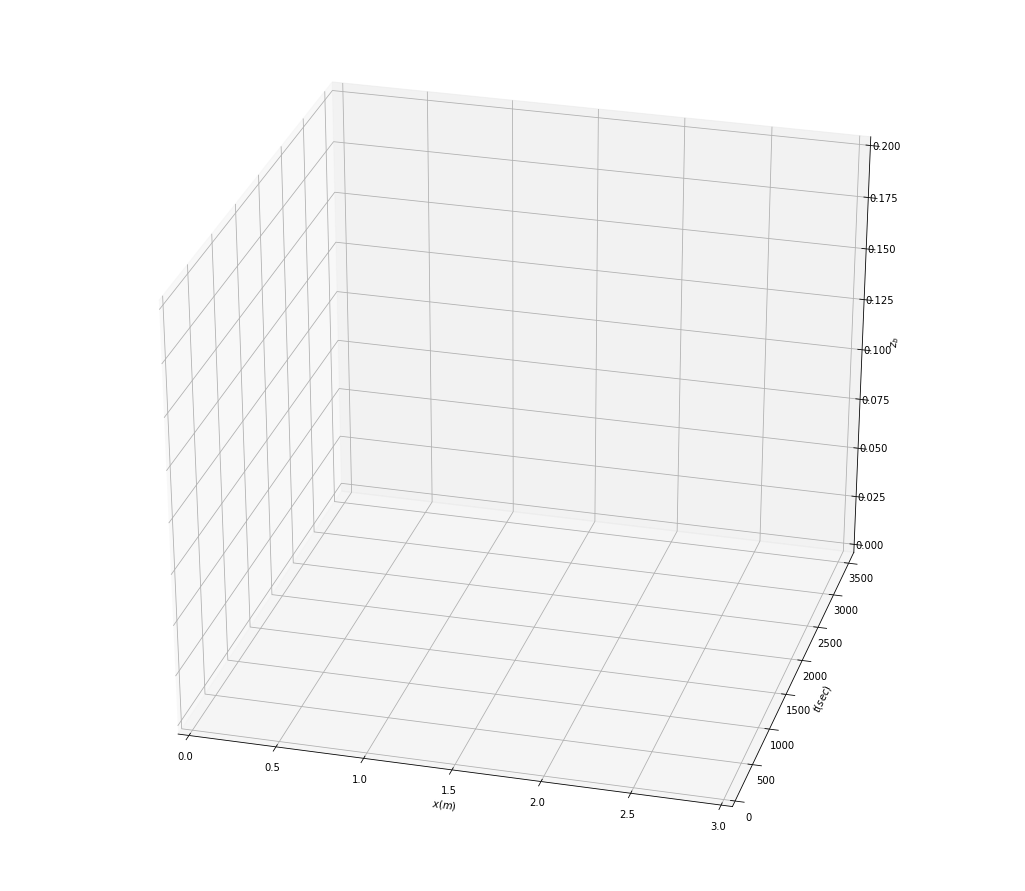

In [56]:
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

lines = LineCollection(verts)

fig = plt.figure(figsize=(18, 16))
ax = fig.gca(projection='3d')
lines.set_alpha(0.7)
ax.add_collection3d(lines, zs=tsteps, zdir='y')
ax.set_xlim3d(0, 3)
ax.set_zlim3d(0, 0.2)
ax.set_ylim3d(0, 3600)
ax.set_zlabel('$z_b$')
ax.set_ylabel('$t(sec)$')
ax.set_xlabel('$x(m)$')

#view_init(elev=None, azim=None)
ax.view_init(30, -75)

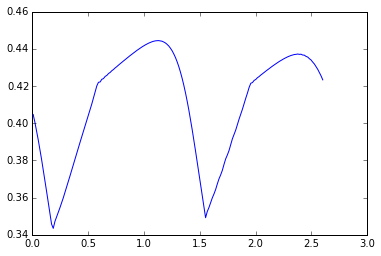

In [8]:
plt.plot(xc,u)
#plt.plot(xc,qbedload*1000000.)

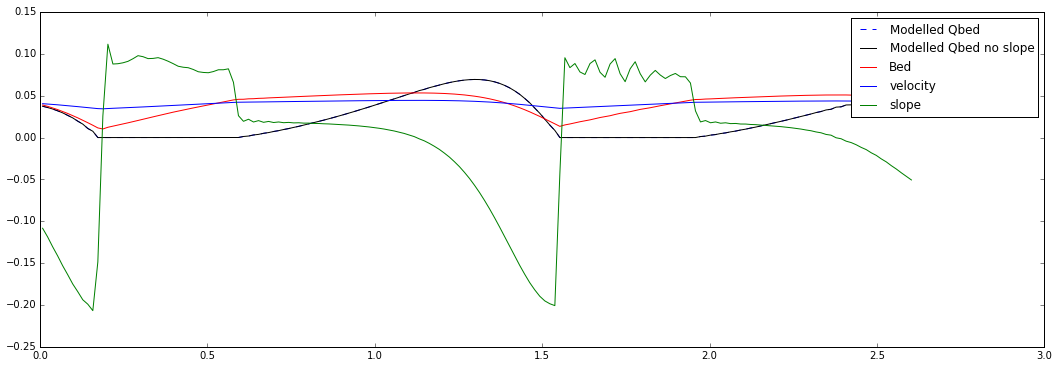

In [15]:
qb=np.zeros(nx)
slope = np.gradient(zc,dx)
for i in range(0,nx): #i=2        
    zlocal = get_stencil(zc,i-2,i+2)
    #qbedload[i] = sedtrans.get_unit_bed_load_slope(h[i],u[i],D50,slope, rho_particule, angleReposeDegrees = 30.0, type='mpm')
    qb[i] = sedtrans.get_unit_bed_load_slope(h[i],u[i],D50,slope[i], rho_particule, angleReposeDegrees = 30.0, type='mpm')
    #qb[i] = sedtrans.get_unit_bed_load2(h[i],u[i],D50,rho_particule, type='mpm')
    
fig = plt.figure(figsize=(18, 6))
plt.plot(xc,qbedload*100000.,'b--', label='Modelled Qbed')
plt.plot(xc,qb*100000.,'k', label='Modelled Qbed no slope')
plt.plot(xc,zc,'r' , label='Bed')
plt.plot(xc,u/10, label='velocity')
plt.plot(xc,slope, label='slope')
plt.legend()

In [10]:
qb_noslope=np.zeros(nx)
qb_slope = np.zeros(nx)
for i in range(0,nx): #i=2        
    zlocal = get_stencil(zn,i-2,i+2)
    #slope = 0.0#(zlocal[3]-zlocal[1]) / dx
    qb_slope[i] = sedtrans.get_unit_bed_load_slope(h[i],u[i],D50,slope[i], rho_particule, angleReposeDegrees = 30.0, type='mpm')
    qb_noslope[i] = sedtrans.get_unit_bed_load2(h[i],u[i],D50,rho_particule, type='mpm')

In [11]:
math.tan(math.pi*30/180.)

0.5773502691896257

In [12]:
gradQbed_slope= np.gradient(qb_slope)
gradqbed_noslope = np.gradient(qb_noslope)

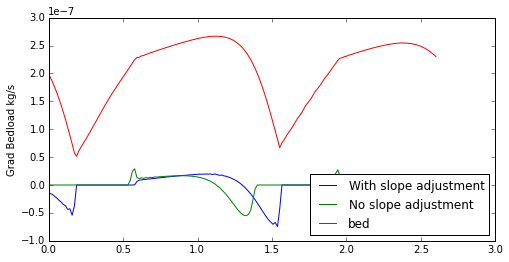

In [13]:
fig = plt.figure(figsize=(8, 4))
plt.plot(xc,gradQbed_slope, label='With slope adjustment')
plt.plot(xc,gradqbed_noslope, label='No slope adjustment')
plt.plot(xc,zc/200000., label='bed')
plt.legend(loc=4)
plt.ylabel('Grad Bedload kg/s')
#plt.plot(xc,slope/10000)

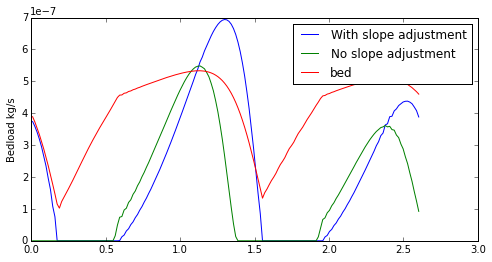

In [18]:
fig = plt.figure(figsize=(8, 4))
plt.plot(xc,qb_slope, label='With slope adjustment')
plt.plot(xc,qb_noslope, label='No slope adjustment')
plt.plot(xc,zc/100000., label='bed')
plt.legend(loc=1)
plt.ylabel('Bedload kg/s')

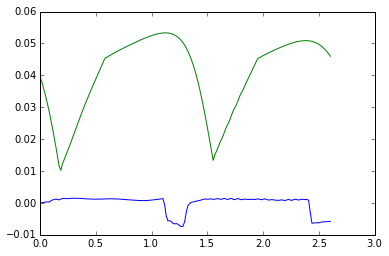

In [19]:
slopZ0 = np.gradient(znew)
plt.plot(xc,slopZ0)
plt.plot(xc,zc)

In [133]:
min(slopZ),max(slopZ)

(-0.0087889091118945398, 0.001573683452594489)